## Setup

### Modules

Import `gensim`, which provides extremely readable implementations of Doc2Vec for generating document embeddings or paragraph vectors which we use as the feature matrix to train our models. The classification algorithms used in the models include the implementations of sklearn for machine learning classifiers.

In [25]:
from __future__ import print_function

#numpy
import numpy as np

#Time
import time

#dump
import pickle

#Graphing Tools
import pandas as pd
import itertools
import matplotlib.pyplot as plt

#Gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from random import shuffle

#Classifiers and Evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
# from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
#from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics


### Input Format


We use four documents for training and testing purposes which are described below:

- `Train_CyberBullying_Dataset.csv`: 5317 Cyber Agressive Comments as Training Data
- `Train_NonCyberBullying_Dataset.csv`: 15328 Non Cyber Agressive Comments as Training Data
- `Test_CyberBullying_Dataset.csv`: 2505 Cyber Agressive Comments as Training Data
- `Test_NonCyberBullying_Dataset.csv`: 6312 Non Cyber Agressive Comments as Training Data

The data contained in these Files have been collected from Kaggle and other sources and have been segregated according to their labels. The total data was split into 20845 training data and 8817 testing data which were further split into CyberBullying and Non CyberBullying categories into their respective files.

Each of the files should be formatted as such:

```
Nope. I know a little thai and some spanish. haha go figure.Im seriously the whitest korean chick you'd ever meet :]
Idk I think it swings both ways pretty strongly. The human race is never satisfied and I believe that both sexes have    
the tendencey to cheat. At all ages and for all reasons.
Timmy. He held me down and tickled me
im not the one who called you a whore either haha. i play soccer and run track and did dance for eight years and did      
gymnastics
What would a chair look like if your knees bent the other way?
formspringg haha noo..my boyfriend. Were always out staying busy.
Would you rather be rich or famous?
crude?
Haha youu need a phone !(:
you should ask her if shes still 
r Has anybody ever told you that!

```

The sample up there contains 10 non cyber aggressive comments, each one taking up one entire line. Yes, **each comment should be on one line, separated by new lines**. This is extremely important, because our parser depends on this to identify sentences.

### Feeding Input Text Data to Doc2Vec for training and generation of document embeddings


The sentences are tokenized and each set of tokens is associated with a paragraph id or tag before training, indicating the document type the sentence comes from. For convenience in our experimentation, we generatethe document ids with respect to the files the comments come from, because of which the training and testing data is split into a pair of files each containing cyber-aggressive and non cyber-aggressive comments. The tags are then conveniently generated with a prefix indicating whether the data is from training or testing dataset and whether
it is cyber-aggressive or non cyber-aggressive. This prefix is coupled with a unique index for each comment for uniqueness and to facilitate retrieval of vectors after training.

In [26]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
        print(flipped)
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    

In [27]:
sources = {'Train_CyberBullying_Dataset.csv':'TRAIN_CB', 'Train_NotCyberBullying_Dataset.csv':'TRAIN_NCB','Test_CyberBullying_Dataset.csv':'TEST_CB', 'Test_NotCyberBullying_Dataset.csv':'TEST_NCB'}
sentences = LabeledLineSentence(sources)

{'TRAIN_CB': ['Train_CyberBullying_Dataset.csv'], 'TRAIN_NCB': ['Train_NotCyberBullying_Dataset.csv'], 'TEST_CB': ['Test_CyberBullying_Dataset.csv'], 'TEST_NCB': ['Test_NotCyberBullying_Dataset.csv']}


In [28]:
sentences.to_array()

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


[LabeledSentence(words=['Get', 'fucking', 'real', 'dude.'], tags=['TRAIN_CB_0']),
 LabeledSentence(words=['She', 'is', 'as', 'dirty', 'as', 'they', 'come', 'and', 'that', 'crook', 'Rengel', 'the', 'Dems', 'are', 'so', 'fucking', 'corrupt', "it's", 'a', 'joke.', 'Make', 'Republicans', 'look', 'like', '...'], tags=['TRAIN_CB_1']),
 LabeledSentence(words=['why', 'did', 'you', 'fuck', 'it', 'up.', 'I', 'could', 'do', 'it', 'all', 'day', 'too.', "Let's", 'do', 'it', 'when', 'you', 'have', 'an', 'hour.', 'Ping', 'me', 'later', 'to', 'sched', 'writing', 'a', 'book', 'here.'], tags=['TRAIN_CB_2']),
 LabeledSentence(words=['Dude', 'they', 'dont', 'finish', 'enclosing', 'the', 'fucking', 'showers.', 'I', 'hate', 'half', 'assed', 'jobs.', 'Whats', 'the', 'reasononing', 'behind', 'it?', 'Makes', 'no', 'sense.'], tags=['TRAIN_CB_3']),
 LabeledSentence(words=['WTF', 'are', 'you', 'talking', 'about', 'Men?', 'No', 'men', 'thats', 'not', 'a', 'menage', "that's", 'just', 'gay.'], tags=['TRAIN_CB_4']),


## Model
This aggregation of tagged tokenized comments from training and testing pairs of datasets are shuffled randomly for
better training and eliminating any dependency on the order of feeding the input, are then fed to the Doc2Vec model for training. The training has been performed for 10 epochs in order to obtain better results. Typically 10 epochs
is found to be sufficiently suitable for generating favourable features and therefore our experimentation includes this parameter as such. After training is performed, we extract the feature vectors for training and testing data into separate arrays with their corresponding labels in separate arrays, for being fed to machine learning algorithms for classification. The number of dimensions of the dense feature vectors has been chosen to be 100, found to be optimum.learning algorithms. Since the training arrays are arranged such that the cyber-aggressive and non cyber-aggressive comments are grouped together, we shuffle the arrays randomly to ensure that the models remain independent of the feeding order of the input vectors.

In [29]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences.to_array())

sentences_list=sentences.to_array()

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


In [30]:
#Creating Permutations of Training Data for effective Training of the model

Idx=list(range(len(sentences_list)))
for epoch in range(10):
  shuffle(Idx)
  perm_sentences = [sentences_list[i] for i in Idx]
  model.train(perm_sentences,total_examples=model.corpus_count,epochs=model.iter)

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


Here's a sample vector for the first sentence in the training set for Cyber Bullying Comments:

In [31]:
model.docvecs['TRAIN_CB_1']

array([-0.12, -0.13, -0.05,  0.02,  0.24, -0.01,  0.05, -0.17,  0.11,
        0.16,  0.07, -0.2 ,  0.11, -0.06,  0.02, -0.07, -0.09, -0.07,
       -0.07, -0.21,  0.22,  0.09,  0.17,  0.04,  0.1 , -0.07, -0.08,
       -0.13,  0.02, -0.14,  0.02, -0.09, -0.2 , -0.02, -0.11, -0.03,
        0.02, -0.03, -0.04,  0.38,  0.02, -0.12, -0.22,  0.12, -0.05,
       -0.22, -0.15,  0.11, -0.06,  0.07,  0.1 , -0.08,  0.11, -0.06,
       -0.06, -0.04,  0.16, -0.01, -0.15, -0.23,  0.09, -0.1 , -0.03,
        0.15,  0.09,  0.03,  0.15,  0.03, -0.09,  0.14, -0.02, -0.13,
       -0.06, -0.09, -0.09,  0.12,  0.23, -0.09,  0.21,  0.09,  0.18,
        0.07,  0.01, -0.16,  0.07,  0.28, -0.21,  0.09, -0.04,  0.02,
        0.05, -0.12, -0.21,  0.07, -0.2 ,  0.06, -0.15, -0.15, -0.05,
        0.02], dtype=float32)

In [32]:
c=["fucking","you","bitch"]
x=model.infer_vector(c)
x

array([-6.62e-03, -1.27e-02,  4.18e-03,  1.10e-02,  1.43e-02, -9.60e-03,
        3.87e-03, -1.20e-03,  6.83e-04,  1.57e-03,  1.80e-03, -9.82e-03,
        1.23e-02,  2.81e-03,  3.47e-03, -6.27e-03, -7.13e-03, -9.40e-03,
       -6.76e-03, -1.19e-02,  4.73e-03,  4.24e-03,  2.23e-03, -4.09e-03,
        1.67e-03,  1.12e-03,  3.11e-03, -1.01e-02,  8.34e-03, -7.39e-03,
        3.81e-03,  1.95e-03,  8.35e-04, -9.42e-04,  8.40e-05, -4.05e-04,
       -3.79e-03, -7.83e-03,  3.26e-03,  7.32e-03,  1.42e-02,  2.82e-03,
       -9.18e-03,  1.52e-02, -5.09e-03,  1.02e-03,  1.41e-03, -2.21e-03,
       -1.19e-03, -4.25e-04, -6.40e-03, -4.27e-03,  1.05e-02, -4.81e-03,
       -6.25e-03,  3.25e-03, -7.81e-04,  3.61e-04, -1.89e-03,  5.17e-04,
       -6.88e-03,  1.56e-04,  4.34e-03,  4.92e-03, -7.91e-03, -6.41e-04,
        1.26e-03, -7.26e-03, -5.52e-04,  8.78e-03,  2.04e-02, -1.09e-03,
       -5.41e-03, -1.09e-02, -2.80e-04, -3.42e-03,  1.30e-02, -9.75e-03,
       -1.16e-02,  8.83e-04,  1.70e-02,  8.19e-03, 

### Saving and Loading Models

To avoid training the model again, we can save it.

In [33]:
model.save('./cb.d2v')

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


And load it.

In [34]:
model = Doc2Vec.load('./cb.d2v')

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Classifying Comments

### Training Vectors

Now let's use these vectors to train a classifier. First, we must extract the training vectors. Remember that we have a total of 20645 training reviews, with 5317 Cyber aggressive comments and 15328 Non Cyber aggressive comments.

We simply put the aggressive ones at the first half of the array, and the non aggressive ones at the second half.

In [35]:
train_arrays = np.zeros((14441, 100))
train_labels = np.zeros(14441)

for i in range(5317):
        prefix_train_CB = 'TRAIN_CB_' + str(i)
        train_arrays[i] = model.docvecs[prefix_train_CB]
        train_labels[i] = 1
for i in range(9124):
        prefix_train_NCB = 'TRAIN_NCB_' + str(i)
        train_arrays[5317+i] = model.docvecs[prefix_train_NCB]
        train_labels[5317 + i] = 0


The training array looks like this: rows and rows of vectors representing each sentence.

In [36]:
print(train_arrays)

[[-0.05 -0.05  0.02 ... -0.08 -0.07  0.04]
 [-0.12 -0.13 -0.05 ... -0.15 -0.05  0.02]
 [-0.02  0.02  0.02 ... -0.05  0.16  0.1 ]
 ...
 [-0.09 -0.02 -0.07 ... -0.01  0.01 -0.01]
 [-0.1  -0.02 -0.12 ...  0.04 -0.01  0.04]
 [-0.1  -0.03 -0.12 ... -0.01 -0.03  0.02]]


The labels are simply category labels for the sentence vectors -- 1 representing positive and 0 for negative.

In [37]:
print(train_labels)

[1. 1. 1. ... 0. 0. 0.]


### Testing Vectors

We do the same for testing data -- data that we are going to feed to the classifier after we've trained it using the training data. This allows us to evaluate our results. The process is pretty much the same as extracting the results for the training data.

In [38]:
test_arrays = np.zeros((5560, 100))
test_labels = np.zeros(5560)

for i in range(2505):
    prefix_test_CB = 'TEST_CB_' + str(i)
    test_arrays[i] = model.docvecs[prefix_test_CB]
    test_labels[i] = 1
for i in range(3055):
    prefix_test_NCB = 'TEST_NCB_' + str(i)
    test_arrays[2505 + i] = model.docvecs[prefix_test_NCB]
    test_labels[2505 + i] = 0


### Classification

Now we train the different classifiers using the training data.Prediction accuracy and time taken by each is calculated.

In [39]:
#KNN
start=time.time()
K_value = 1
clf_knn = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
clf_knn.fit(train_arrays, train_labels) 
y_pred_knn = clf_knn.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_knn)*100,"% for K-Value:",K_value,"Time taken:",(end-start))


#Logistic Regression
start=time.time()
clf_logistic = LogisticRegression()
clf_logistic.fit(train_arrays, train_labels)
y_pred_logistic=clf_logistic.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_logistic)*100,"% for Logistic regression","Time taken:",(end-start))



#Support Vector Machine
s=['linear', 'poly', 'rbf']
for kernel in s:
    start=time.time()
    clf_svm = svm.SVC(kernel=kernel, gamma=2)
    clf_svm.fit(train_arrays, train_labels)
    y_pred_svm=clf_svm.predict(test_arrays)
    end=time.time()
    print( "Accuracy is ",accuracy_score(test_labels,y_pred_svm)*100,"% for SVM with kernel = ",kernel,"Time taken:",(end-start))
clf_svm = svm.SVC(kernel='rbf', gamma=2)

#Random forest classifier
start=time.time()
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(n_estimators=20)
clf_forest.fit(train_arrays,train_labels)
y_pred_forest = clf_forest.predict(test_arrays)
end=time.time()
print( "Accuracy is ", accuracy_score(test_labels,y_pred_forest)*100,"% for Random Forest Classifier","Time taken:",(end-start))


#Bernoulli Naive Bayes
start=time.time()
from sklearn.naive_bayes import BernoulliNB
clf_Ber = BernoulliNB()
clf_Ber.fit(train_arrays,train_labels)
y_pred_Ber = clf_Ber.predict(test_arrays)
end=time.time()
print("Accuracy is ",accuracy_score(test_labels, y_pred_Ber)*100,"% for Bernoulli Naive Bayes","Time taken:",(end-start))


#Decision Tree
start=time.time()
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5)
clf_gini.fit(train_arrays,train_labels)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')
y_pred_tree = clf_gini.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_tree)*100,"% for Decision Tree","Time taken:",(end-start))




Accuracy is  91.97841726618705 % for K-Value: 1 Time taken: 12.908464670181274


C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is  63.16546762589928 % for Logistic regression Time taken: 0.3730041980743408
Accuracy is  54.94604316546763 % for SVM with kernel =  linear Time taken: 43.48766231536865
Accuracy is  73.36330935251797 % for SVM with kernel =  poly Time taken: 49.33301568031311
Accuracy is  79.42446043165468 % for SVM with kernel =  rbf Time taken: 43.27713465690613
Accuracy is  83.84892086330935 % for Random Forest Classifier Time taken: 4.206745624542236
Accuracy is  71.78057553956835 % for Bernoulli Naive Bayes Time taken: 0.077789306640625
Accuracy is  60.935251798561154 % for Decision Tree Time taken: 0.7110986709594727


In [19]:
z1=clf_knn.predict(x.reshape(1,100))
print(z1)

[0.]


In [21]:
knnPickle = open('knnpickle_file', 'wb') 
pickle.dump(clf_knn, knnPickle)                      




Confusion matrix, without normalization
[[2677  378]
 [  57 2448]]


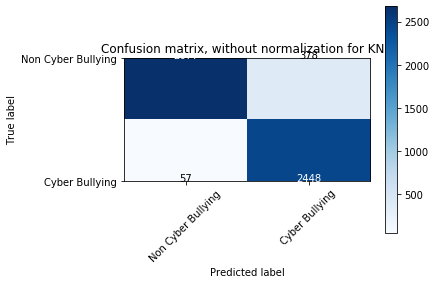

Confusion matrix, without normalization
[[3023   32]
 [1982  523]]


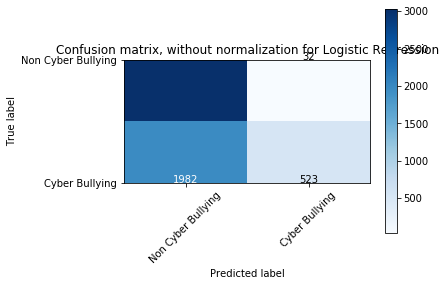

Confusion matrix, without normalization
[[2896  159]
 [ 940 1565]]


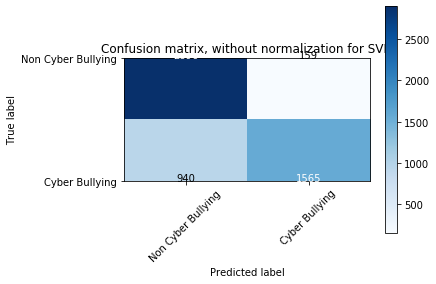

Confusion matrix, without normalization
[[2744  311]
 [1299 1206]]


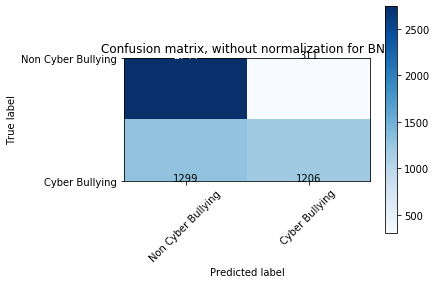

Confusion matrix, without normalization
[[2727  328]
 [1746  759]]


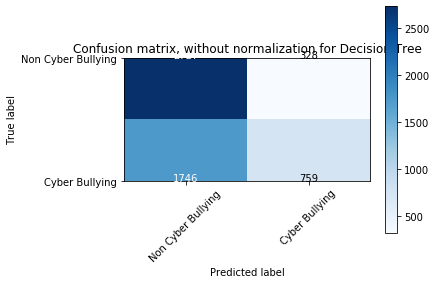

Confusion matrix, without normalization
[[2868  187]
 [ 717 1788]]


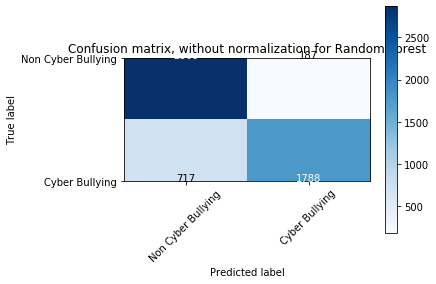

----------------------------------------------------------------------------------------------------------------
Cross Validation Scores and standard deviation for each :-


C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chirag\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: 

Logistic Regression: 0.614048 (0.352887)
KNN: 0.824448 (0.107497)
Random Forest: 0.728492 (0.164668)
Decision Tree: 0.657188 (0.299175)
Bernouli Navie Byes: 0.615825 (0.153389)


In [24]:
class_names=['Non Cyber Bullying','Cyber Bullying']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#KNN
# Compute confusion matrix for KNN
cnf_matrix = confusion_matrix(test_labels, y_pred_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for KNN')

plt.show()


#Logistic Regression
# Compute confusion matrix for Logistic Regression
cnf_matrix = confusion_matrix(test_labels, y_pred_logistic)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Logistic Regression')
plt.show()


#Support Vector Machine
# Compute confusion matrix for SVM
cnf_matrix = confusion_matrix(test_labels, y_pred_svm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for SVM')
plt.show()


#Bernoulli Naive Bayes
# Compute confusion matrix for GNB
cnf_matrix = confusion_matrix(test_labels, y_pred_Ber)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for BNB')

plt.show()

#Decision Tree
# Compute confusion matrix for Decision Tree
cnf_matrix = confusion_matrix(test_labels, y_pred_tree)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Decision Tree')

plt.show()

#Random forest classifier
cnf_matrix = confusion_matrix(test_labels, y_pred_forest)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Random Forest')

plt.show()

### K-fold Cross Validation
print("----------------------------------------------------------------------------------------------------------------")
print("Cross Validation Scores and standard deviation for each :-")
##Comparison graphs
from sklearn import model_selection
X = train_arrays
y = train_labels
# prepare configuration for cross validation test harness
seed = 7
models = []
models.append(('Logistic Regression',clf_logistic ))
models.append(('KNN', clf_knn))
models.append(('Random Forest', clf_forest))
models.append(('Decision Tree', clf_gini))
models.append(('Bernouli Navie Byes', clf_Ber))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=20, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
#fig = plt.figure()
#fig.suptitle('Algorithm Comparison')
#ax = fig.add_subplot(111)
#plt.boxplot(results)
#ax.set_xticklabels(names)
#plt.show()